In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/dataset1'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=2000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Add weight decay for L2 regularization


In [ ]:
# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10], Loss: 2.6075, Accuracy: 34.75%, Test Loss: 1.3844, Test Accuracy: 41.80%
Epoch [2/10], Loss: 1.0343, Accuracy: 60.80%, Test Loss: 1.0894, Test Accuracy: 57.83%
Epoch [3/10], Loss: 0.7302, Accuracy: 74.10%, Test Loss: 1.0244, Test Accuracy: 59.27%
Epoch [4/10], Loss: 0.4844, Accuracy: 85.95%, Test Loss: 1.0563, Test Accuracy: 59.43%
Epoch [5/10], Loss: 0.3258, Accuracy: 92.35%, Test Loss: 1.1181, Test Accuracy: 61.17%
Epoch [6/10], Loss: 0.2050, Accuracy: 95.80%, Test Loss: 1.2331, Test Accuracy: 58.40%
Epoch [7/10], Loss: 0.1615, Accuracy: 97.15%, Test Loss: 1.1973, Test Accuracy: 60.40%
Epoch [8/10], Loss: 0.0975, Accuracy: 98.75%, Test Loss: 1.3052, Test Accuracy: 58.93%
Epoch [9/10], Loss: 0.0797, Accuracy: 99.05%, Test Loss: 1.2636, Test Accuracy: 62.03%
Epoch [10/10], Loss: 0.0565, Accuracy: 99.60%, Test Loss: 1.3438, Test Accuracy: 61.30%


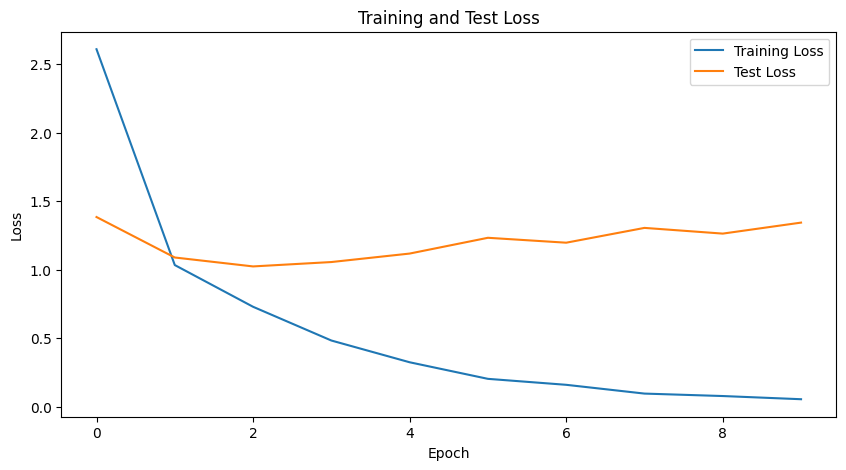

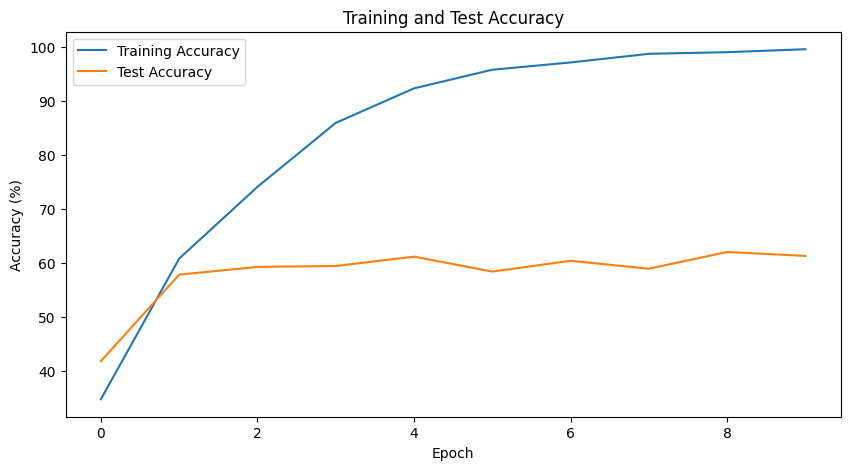

In [ ]:
# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

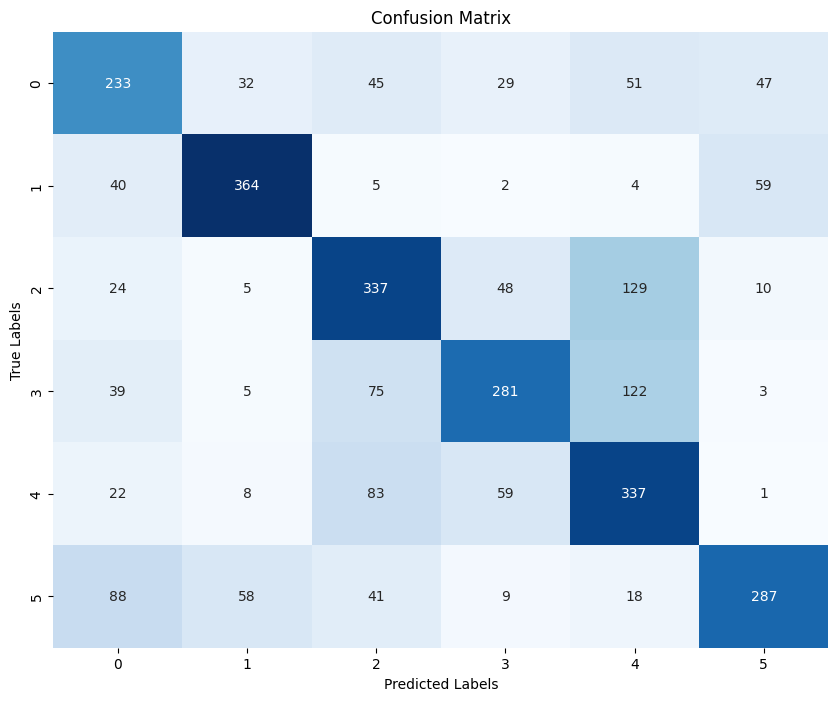

In [ ]:
# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/10], Loss: 2.1930, Accuracy: 38.65%, Test Loss: 1.2936, Test Accuracy: 49.50%
Epoch [2/10], Loss: 1.0861, Accuracy: 57.85%, Test Loss: 1.0787, Test Accuracy: 58.63%
Epoch [3/10], Loss: 0.8968, Accuracy: 66.40%, Test Loss: 1.0541, Test Accuracy: 59.23%
Epoch [4/10], Loss: 0.7524, Accuracy: 74.55%, Test Loss: 1.0061, Test Accuracy: 62.53%
Epoch [5/10], Loss: 0.7128, Accuracy: 74.05%, Test Loss: 0.9777, Test Accuracy: 63.13%
Epoch [6/10], Loss: 0.5805, Accuracy: 81.45%, Test Loss: 0.9918, Test Accuracy: 61.97%
Epoch [7/10], Loss: 0.5137, Accuracy: 83.00%, Test Loss: 1.0649, Test Accuracy: 60.97%
Epoch [8/10], Loss: 0.4261, Accuracy: 87.85%, Test Loss: 1.0822, Test Accuracy: 60.27%
Epoch [9/10], Loss: 0.3685, Accuracy: 90.10%, Test Loss: 1.1307, Test Accuracy: 58.80%
Epoch [10/10], Loss: 0.3431, Accuracy: 90.35%, Test Loss: 1.1465, Test Accuracy: 61.97%


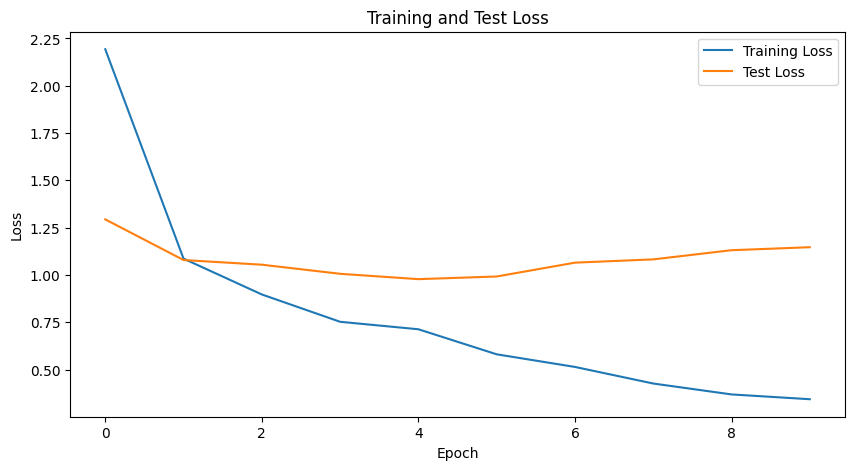

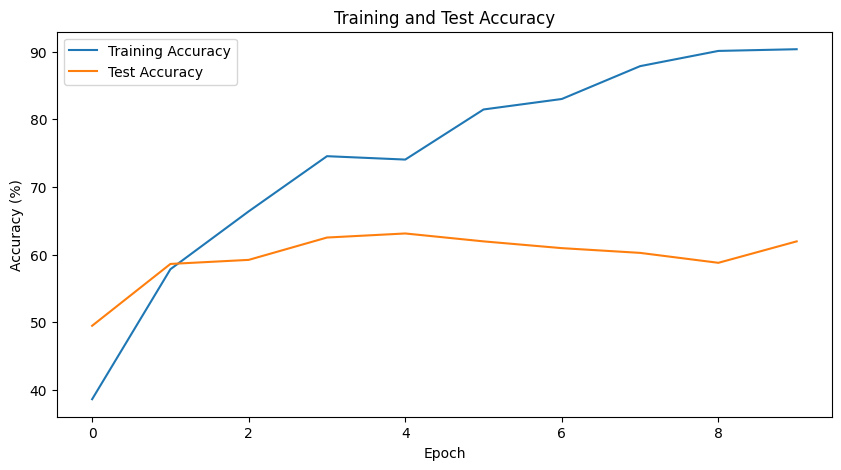

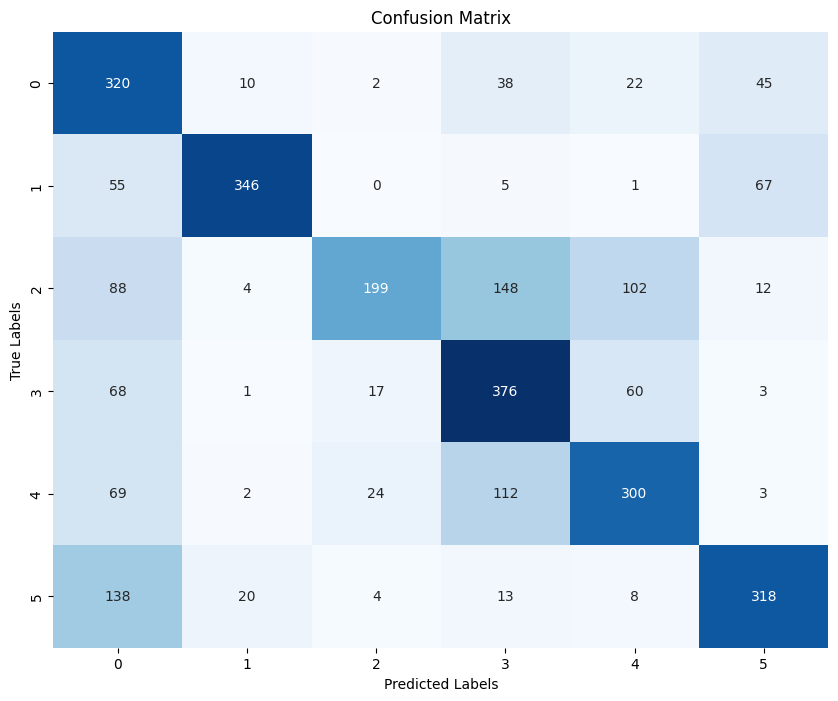

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=2000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.05)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/10], Loss: 2.3266, Accuracy: 40.45%, Test Loss: 1.2598, Test Accuracy: 52.30%
Epoch [2/10], Loss: 1.1335, Accuracy: 56.30%, Test Loss: 1.0907, Test Accuracy: 56.53%
Epoch [3/10], Loss: 0.9959, Accuracy: 63.40%, Test Loss: 1.0493, Test Accuracy: 61.03%
Epoch [4/10], Loss: 0.9312, Accuracy: 64.75%, Test Loss: 1.1954, Test Accuracy: 52.60%
Epoch [5/10], Loss: 0.9019, Accuracy: 65.90%, Test Loss: 1.0986, Test Accuracy: 58.47%
Epoch [6/10], Loss: 0.8949, Accuracy: 67.70%, Test Loss: 1.0029, Test Accuracy: 63.93%
Epoch [7/10], Loss: 0.8542, Accuracy: 67.85%, Test Loss: 0.9996, Test Accuracy: 60.77%
Epoch [8/10], Loss: 0.7872, Accuracy: 72.85%, Test Loss: 1.1071, Test Accuracy: 56.63%
Epoch [9/10], Loss: 0.8289, Accuracy: 69.60%, Test Loss: 1.0179, Test Accuracy: 60.97%
Epoch [10/10], Loss: 0.8072, Accuracy: 69.60%, Test Loss: 1.0001, Test Accuracy: 62.03%


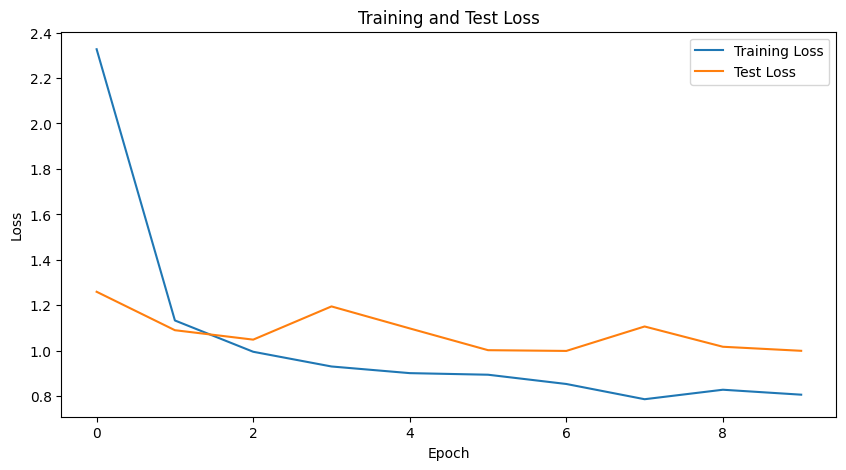

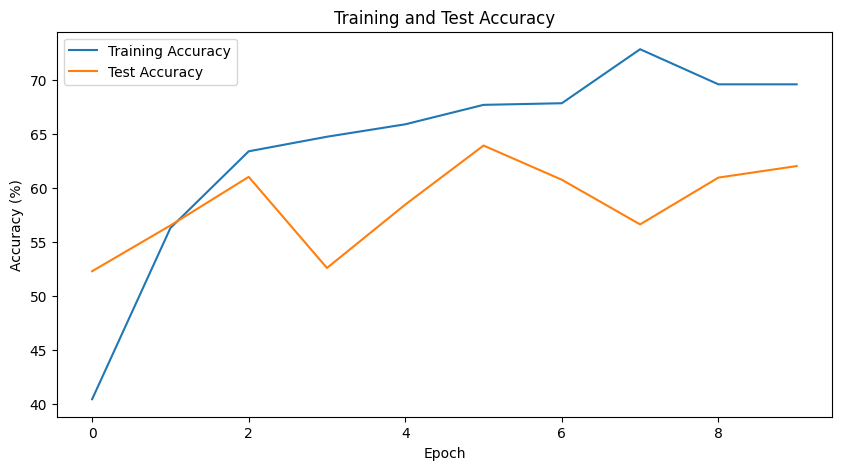

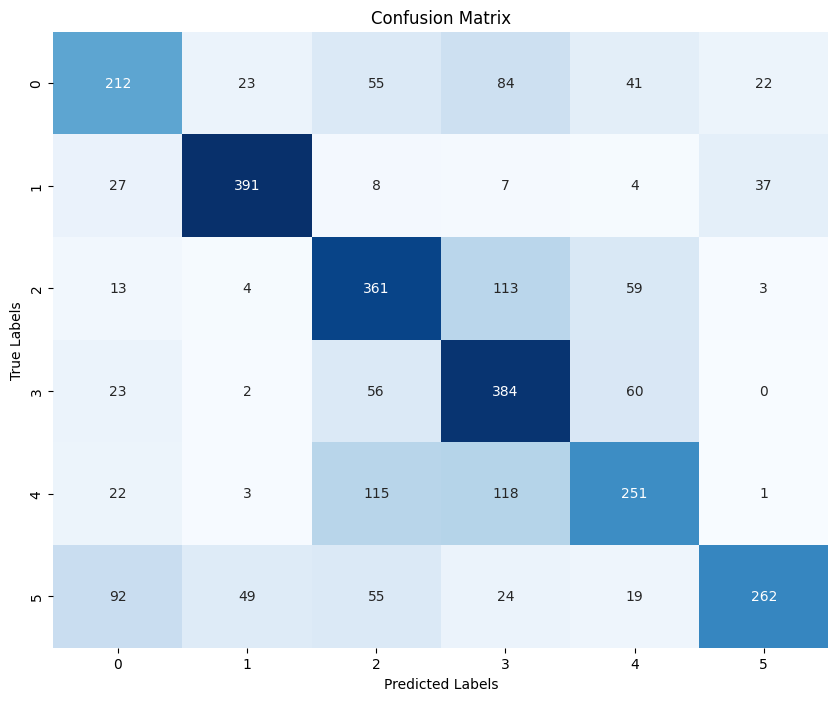

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=2000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/10], Loss: 2.6951, Accuracy: 36.55%, Test Loss: 1.3902, Test Accuracy: 46.93%
Epoch [2/10], Loss: 1.2453, Accuracy: 53.70%, Test Loss: 1.2207, Test Accuracy: 53.50%
Epoch [3/10], Loss: 1.1302, Accuracy: 57.65%, Test Loss: 1.1514, Test Accuracy: 56.03%
Epoch [4/10], Loss: 1.0938, Accuracy: 59.45%, Test Loss: 1.1811, Test Accuracy: 52.73%
Epoch [5/10], Loss: 1.0394, Accuracy: 61.15%, Test Loss: 1.1394, Test Accuracy: 53.87%
Epoch [6/10], Loss: 1.0562, Accuracy: 58.75%, Test Loss: 1.1382, Test Accuracy: 55.23%
Epoch [7/10], Loss: 1.0194, Accuracy: 59.05%, Test Loss: 1.0985, Test Accuracy: 58.27%
Epoch [8/10], Loss: 1.0033, Accuracy: 62.10%, Test Loss: 1.1751, Test Accuracy: 51.80%
Epoch [9/10], Loss: 0.9955, Accuracy: 60.80%, Test Loss: 1.0636, Test Accuracy: 58.20%
Epoch [10/10], Loss: 0.9593, Accuracy: 64.40%, Test Loss: 1.0994, Test Accuracy: 57.37%


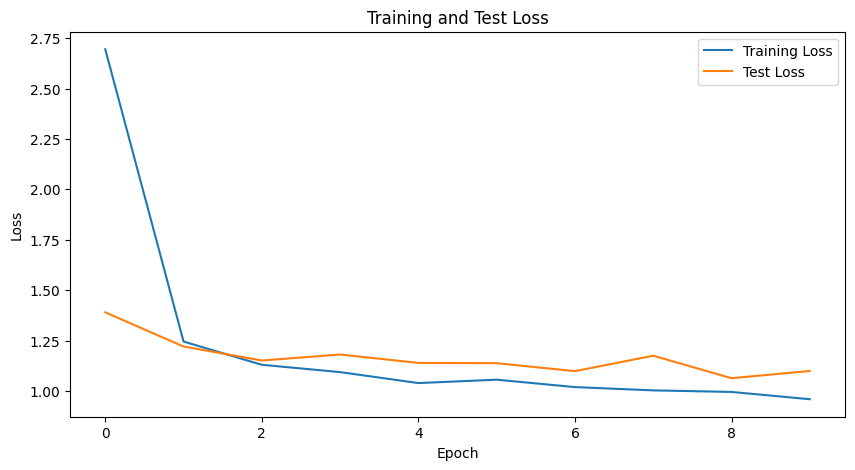

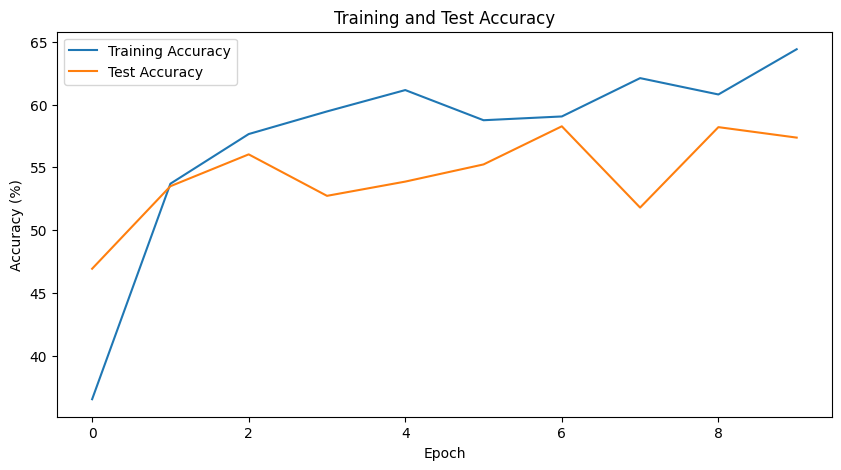

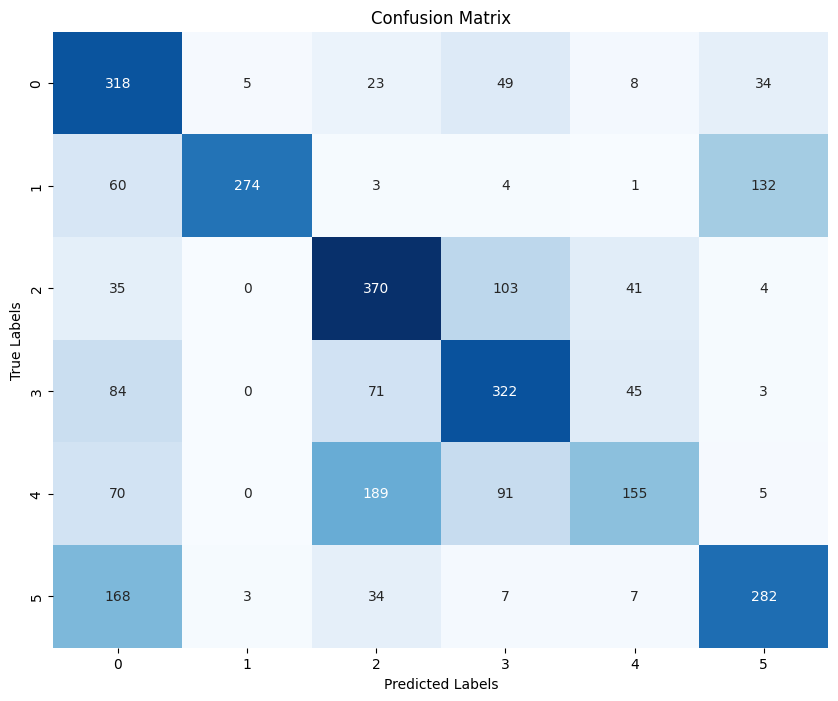

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=2000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.10)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/10], Loss: 2.0158, Accuracy: 39.42%, Test Loss: 1.2245, Test Accuracy: 54.20%
Epoch [2/10], Loss: 1.0964, Accuracy: 58.34%, Test Loss: 1.0751, Test Accuracy: 58.53%
Epoch [3/10], Loss: 0.9916, Accuracy: 62.88%, Test Loss: 1.0676, Test Accuracy: 57.67%
Epoch [4/10], Loss: 0.9925, Accuracy: 61.92%, Test Loss: 0.9683, Test Accuracy: 62.70%
Epoch [5/10], Loss: 0.9360, Accuracy: 64.96%, Test Loss: 0.9940, Test Accuracy: 61.53%
Epoch [6/10], Loss: 0.9140, Accuracy: 66.54%, Test Loss: 0.9880, Test Accuracy: 61.90%
Epoch [7/10], Loss: 0.9082, Accuracy: 66.32%, Test Loss: 0.9418, Test Accuracy: 62.83%
Epoch [8/10], Loss: 0.8782, Accuracy: 67.74%, Test Loss: 0.9446, Test Accuracy: 64.53%
Epoch [9/10], Loss: 0.8924, Accuracy: 67.50%, Test Loss: 1.0689, Test Accuracy: 58.90%
Epoch [10/10], Loss: 0.9115, Accuracy: 66.10%, Test Loss: 0.9324, Test Accuracy: 66.23%


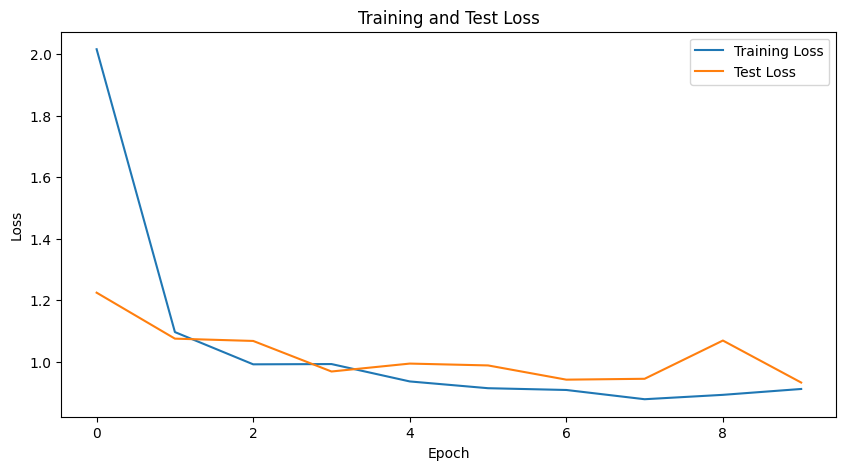

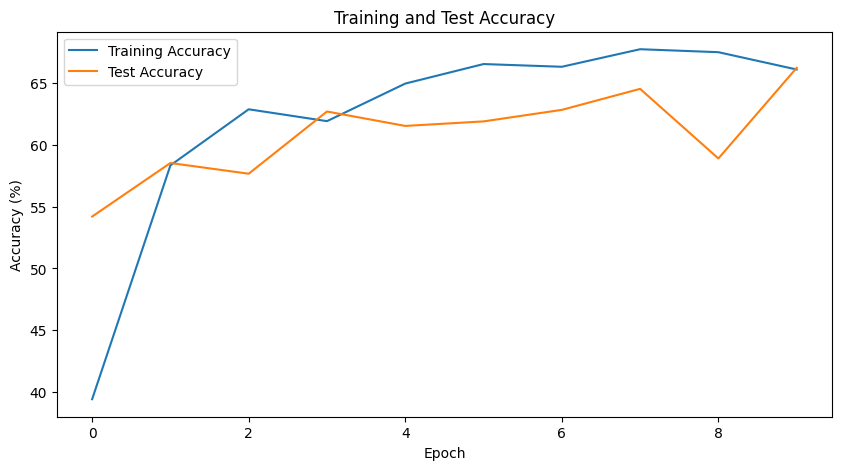

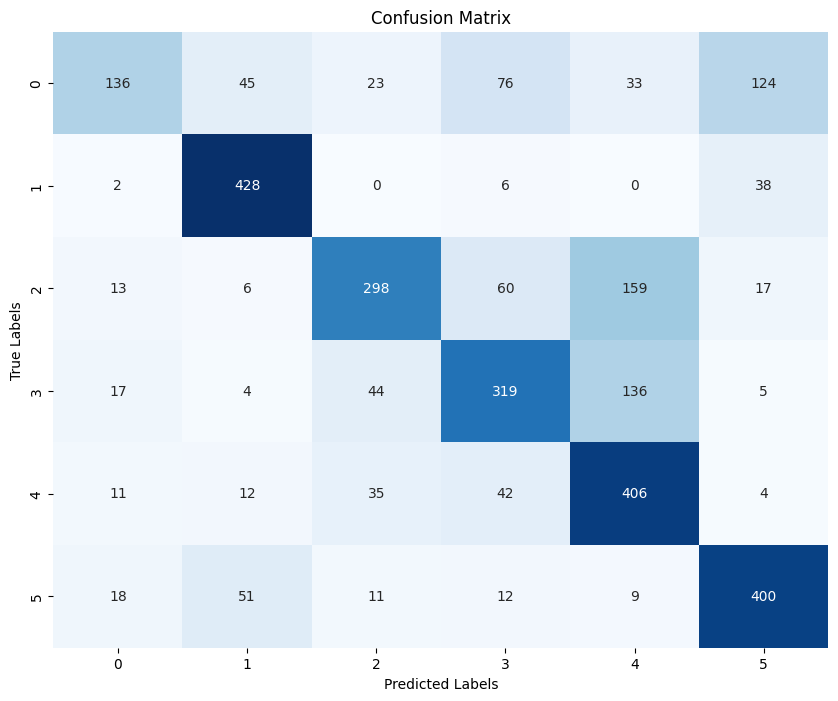

In [ ]:
# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=5000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/10], Loss: 1.8468, Accuracy: 46.98%, Test Loss: 1.1477, Test Accuracy: 56.00%
Epoch [2/10], Loss: 1.0511, Accuracy: 61.10%, Test Loss: 1.1188, Test Accuracy: 53.77%
Epoch [3/10], Loss: 0.9838, Accuracy: 62.72%, Test Loss: 1.0454, Test Accuracy: 58.67%
Epoch [4/10], Loss: 0.9486, Accuracy: 64.02%, Test Loss: 1.0152, Test Accuracy: 60.13%
Epoch [5/10], Loss: 0.9615, Accuracy: 63.64%, Test Loss: 0.9840, Test Accuracy: 63.57%
Epoch [6/10], Loss: 0.9484, Accuracy: 63.98%, Test Loss: 0.9598, Test Accuracy: 64.47%
Epoch [7/10], Loss: 0.9482, Accuracy: 65.10%, Test Loss: 1.0120, Test Accuracy: 61.30%
Epoch [8/10], Loss: 0.9573, Accuracy: 63.34%, Test Loss: 1.0763, Test Accuracy: 58.70%
Epoch [9/10], Loss: 0.9561, Accuracy: 65.06%, Test Loss: 0.9971, Test Accuracy: 62.40%
Epoch [10/10], Loss: 0.9279, Accuracy: 64.84%, Test Loss: 1.0436, Test Accuracy: 59.90%


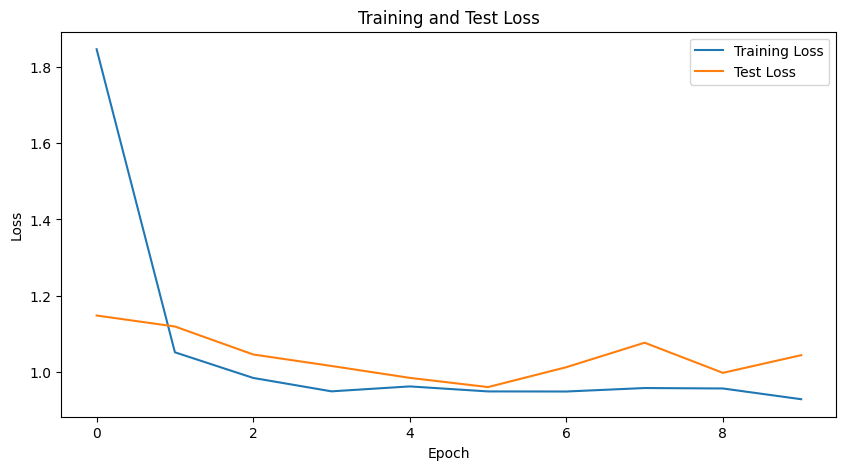

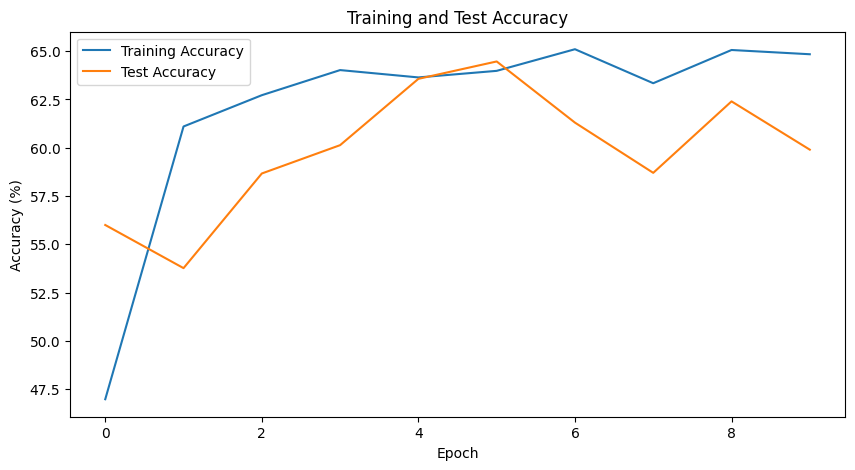

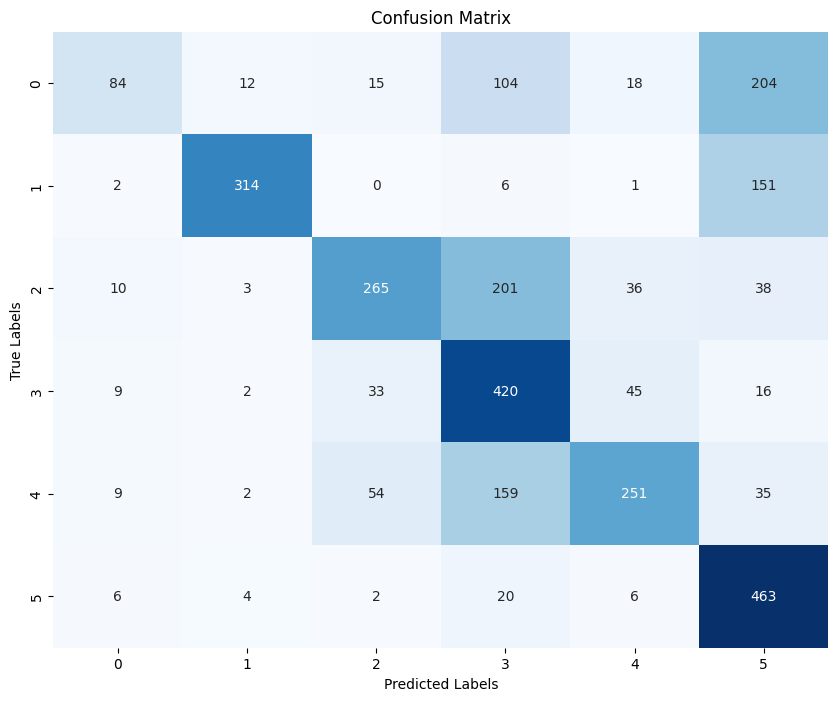

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=5000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 10
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=10000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 50
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/50], Loss: 1.3751, Accuracy: 55.18%, Test Loss: 1.0398, Test Accuracy: 58.20%
Epoch [2/50], Loss: 0.9760, Accuracy: 63.60%, Test Loss: 1.0227, Test Accuracy: 58.87%
Epoch [3/50], Loss: 0.9458, Accuracy: 64.80%, Test Loss: 0.9529, Test Accuracy: 65.77%
Epoch [4/50], Loss: 0.9410, Accuracy: 64.53%, Test Loss: 0.9427, Test Accuracy: 62.83%
Epoch [5/50], Loss: 0.9295, Accuracy: 65.62%, Test Loss: 0.8894, Test Accuracy: 67.70%
Epoch [6/50], Loss: 0.9168, Accuracy: 66.06%, Test Loss: 0.9905, Test Accuracy: 61.40%
Epoch [7/50], Loss: 0.9249, Accuracy: 65.00%, Test Loss: 0.9425, Test Accuracy: 64.27%
Epoch [8/50], Loss: 0.9180, Accuracy: 66.19%, Test Loss: 1.0147, Test Accuracy: 59.17%
Epoch [9/50], Loss: 0.9223, Accuracy: 65.56%, Test Loss: 0.9354, Test Accuracy: 65.70%
Epoch [10/50], Loss: 0.9118, Accuracy: 66.15%, Test Loss: 0.9142, Test Accuracy: 65.80%
Epoch [11/50], Loss: 0.9063, Accuracy: 66.35%, Test Loss: 1.0717, Test Accuracy: 54.17%
Epoch [12/50], Loss: 0.9059, Accuracy: 66

Epoch [1/50], Loss: 1.2656, Accuracy: 54.89%, Test Loss: 0.9942, Test Accuracy: 62.47%
Epoch [2/50], Loss: 0.9853, Accuracy: 63.02%, Test Loss: 1.0497, Test Accuracy: 58.67%
Epoch [3/50], Loss: 0.9653, Accuracy: 63.36%, Test Loss: 0.9731, Test Accuracy: 65.33%
Epoch [4/50], Loss: 0.9473, Accuracy: 65.32%, Test Loss: 0.9981, Test Accuracy: 60.93%
Epoch [5/50], Loss: 0.9371, Accuracy: 64.66%, Test Loss: 1.0223, Test Accuracy: 60.63%
Epoch [6/50], Loss: 0.9452, Accuracy: 64.62%, Test Loss: 0.9748, Test Accuracy: 61.60%
Epoch [7/50], Loss: 0.9238, Accuracy: 66.23%, Test Loss: 0.9931, Test Accuracy: 60.07%
Epoch [8/50], Loss: 0.9142, Accuracy: 66.41%, Test Loss: 0.9982, Test Accuracy: 60.00%
Epoch [9/50], Loss: 0.9261, Accuracy: 65.34%, Test Loss: 1.0394, Test Accuracy: 58.80%
Epoch [10/50], Loss: 0.9307, Accuracy: 65.58%, Test Loss: 0.9464, Test Accuracy: 64.40%
Epoch [11/50], Loss: 0.9332, Accuracy: 65.93%, Test Loss: 0.9030, Test Accuracy: 65.93%
Epoch [12/50], Loss: 0.9193, Accuracy: 66

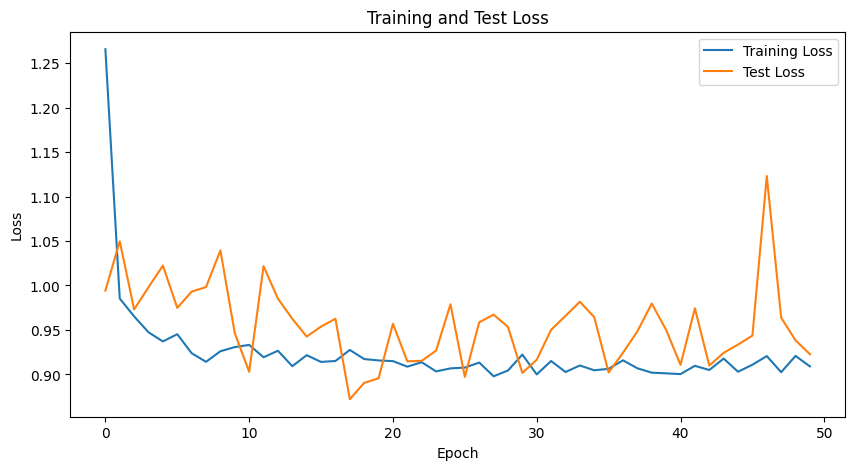

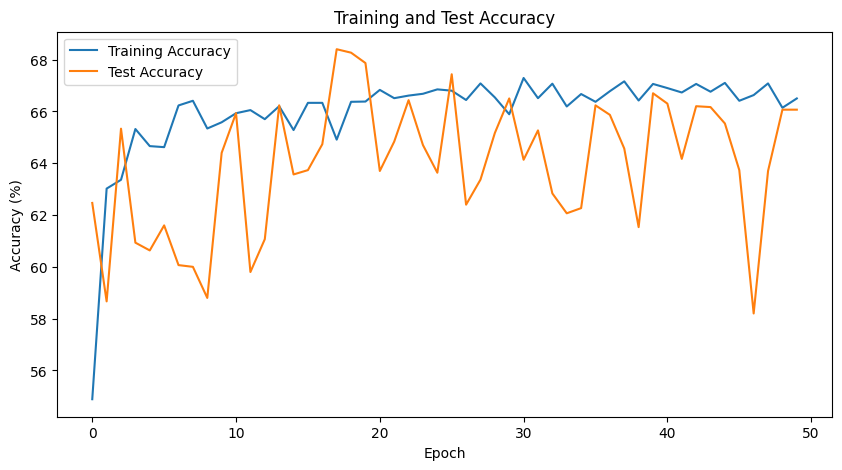

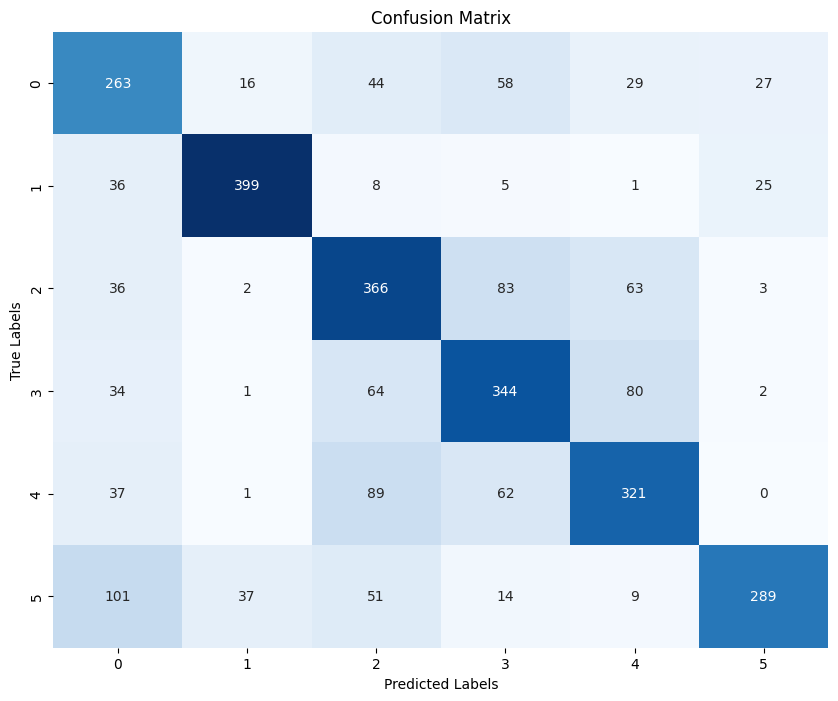

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=10000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 50
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 5% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.05)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to block a percentage of pixels in an image
def block_pixels(image, percentage):
    # Calculate the number of pixels to block
    num_pixels = int(image.size(1) * image.size(2) * percentage)

    # Generate random indices to block
    indices = random.sample(range(image.size(1) * image.size(2)), num_pixels)
    indices = torch.tensor(indices)

    # Set the blocked pixels to zero
    image[:, indices // image.size(2), indices % image.size(2)] = 0

    return image

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_data_path = '/content/drive/MyDrive/dataset1/seg_train'
test_data_path = '/content/drive/MyDrive/dataset1/seg_test'

# Load the training dataset
train_dataset = ImageFolder(train_data_path, transform=transform)

# Use only a subset of 2000 images
random.seed(123)
subset_indices = random.sample(range(len(train_dataset)), k=10000)
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.20)  # Add weight decay for L2 regularization

# Training loop
num_epochs = 50
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Block 1% of the pixels in each image
        for i in range(images.size(0)):
            images[i] = block_pixels(images[i].clone(), 0.01)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Epoch [1/50], Loss: 1.3378, Accuracy: 55.38%, Test Loss: 1.0381, Test Accuracy: 58.60%
Epoch [2/50], Loss: 0.9537, Accuracy: 64.19%, Test Loss: 0.9490, Test Accuracy: 64.83%
Epoch [3/50], Loss: 0.9315, Accuracy: 64.94%, Test Loss: 0.9599, Test Accuracy: 62.70%
Epoch [4/50], Loss: 0.9236, Accuracy: 65.43%, Test Loss: 0.9894, Test Accuracy: 63.20%
Epoch [5/50], Loss: 0.9325, Accuracy: 64.89%, Test Loss: 0.9526, Test Accuracy: 62.60%
Epoch [6/50], Loss: 0.9061, Accuracy: 66.31%, Test Loss: 0.9079, Test Accuracy: 66.33%
Epoch [7/50], Loss: 0.9062, Accuracy: 66.78%, Test Loss: 1.0000, Test Accuracy: 62.63%
Epoch [8/50], Loss: 0.9082, Accuracy: 66.23%, Test Loss: 0.9794, Test Accuracy: 61.60%
Epoch [9/50], Loss: 0.8970, Accuracy: 66.91%, Test Loss: 0.9379, Test Accuracy: 63.80%
Epoch [10/50], Loss: 0.8934, Accuracy: 67.70%, Test Loss: 0.9206, Test Accuracy: 65.20%
Epoch [11/50], Loss: 0.9014, Accuracy: 66.63%, Test Loss: 0.9280, Test Accuracy: 65.40%
Epoch [12/50], Loss: 0.9068, Accuracy: 66